In [72]:
import math
from IPython.display import Image
 
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as ssapi

import seaborn as sns

# 1. Ads Click Through Rate
Dois anúncios. Anúncio #1 tem 1000 impressões e 20 cliques. Enquanto o Anúncio
#2 tem 900 impressões e 30 cliques.
Teste se há diferença entre o CTR do Anúncio #01 e #02

- H0: Não há diferença entre as páginas #1 e #2 (CTR igual)
- H1: Há diferença entre as páginas #1 e #2 (CTR diferente)

In [3]:
df1 = pd.DataFrame({'impressoes':[1000, 900], 'clique':[20, 30], 'anuncio':['#1', '#2']})
df1 = df1.set_index('anuncio')
df1['nao_clique'] = df1['impressoes'] - df1['clique']
df1['conversao'] = df1['clique'] / df1['impressoes']
df1

,impressoes,clique,nao_clique,conversao
anuncio,,,,
#1,1000,20,980,0.020000
#2,900,30,870,0.033333


### Sample size

In [4]:
from statsmodels.stats.proportion import proportion_effectsize

from statsmodels.stats.power import NormalIndPower

In [5]:
def calc_sample_size(power_calculator, alpha, effect_size):
    return power_calculator.solve_power(effect_size=effect_size, alpha=alpha,power=0.8)

In [6]:
def plot_sample_size_by_alpha(power_calculator, effect_size, min_size_of_a_sample):
    df = pd.DataFrame({'alpha':range(5,51)})
    
    df['alpha'] = df['alpha'] / 100
    df['limit_max_sample'] = min_size_of_a_sample
    
    for alpha in df['alpha']:
        df.loc[df['alpha'] == alpha, 'sample_size'] = calc_sample_size(power_calculator, alpha, effect_size)
    
    # qual o menor alpha que gera um sample size menor que a menor amostra
    min_alpha = df.loc[df['sample_size'] < min_size_of_a_sample, 'alpha'].iloc[0]
    print(f'Alpha mínimo: {min_alpha}')
    
    df.plot(x='alpha', y=['sample_size', 'limit_max_sample'], color=['blue', 'red']);

    return None

In [7]:
effect_size = proportion_effectsize(df1.loc['#1', 'conversao'], df1.loc['#2', 'conversao'])

power_calculator = NormalIndPower()

min_sample_size = power_calculator.solve_power(effect_size=effect_size, alpha=0.05,power=0.8)
print(f'Sample size: {math.ceil(min_sample_size)}')

Sample size: 2257


Como o sample size deu muito alto para o alpha de 0.05, vamos verificar qual alpha podemos usar.

Alpha mínimo: 0.35


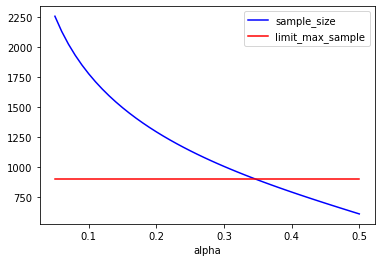

In [8]:
plot_sample_size_by_alpha(power_calculator, effect_size, df1['impressoes'].min())

### Experimento -  Cálculo manual

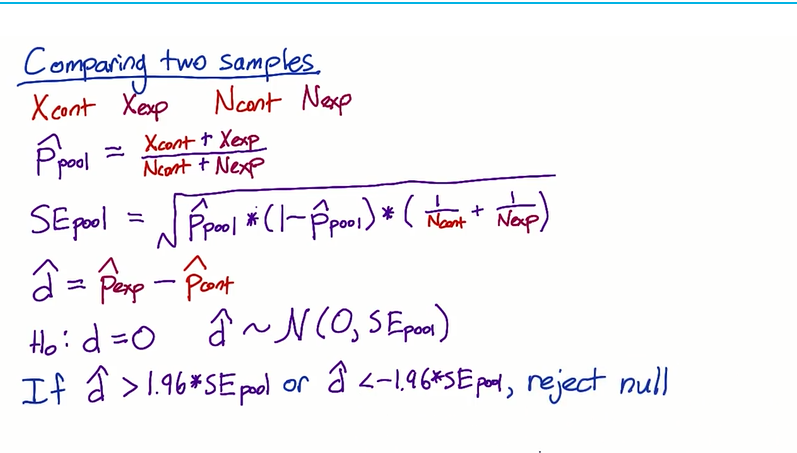

In [9]:
Image("../imgs/ctr_calc.png")

In [10]:
# "media" de probabilidade
p_hat_pool = df1['clique'].sum() / df1['impressoes'].sum()

# standart error
SE_pool = math.sqrt(p_hat_pool * (1-p_hat_pool)  *  (1/df1.loc['#1', 'impressoes'] + 1/df1.loc['#2', 'impressoes']) )

# diferença observada
d_hat = df1.loc['#2', 'conversao'] - df1.loc['#1', 'conversao']

# margem de erro
Z = 1.96 # 0.95 na tabela z score
m = Z * SE_pool

print(f'p_hat_pool: {SE_pool:.4f}')
print(f'SE_pool: {p_hat_pool:.4f}')
print(f'd_hat: {d_hat:.4f}')
print(f'margem de erro: {m:.4f}')

p_hat_pool: 0.0074
SE_pool: 0.0263
d_hat: 0.0133
margem de erro: 0.0144


In [11]:
if d_hat > m or  d_hat < -m:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Falhou em rejeitar a nula


### Experimento - Z Test

In [12]:
x1 = [0]*df1.loc['#1', 'nao_clique'] + [1]*df1.loc['#1', 'clique']
x2 = [0]*df1.loc['#2', 'nao_clique'] + [1]*df1.loc['#2', 'clique']

In [13]:
_, p_value = ssapi.ztest(x1=x1,x2=x2)
print(f'p value: {p_value}')

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

p value: 0.06975756965466925
Falhou em rejeitar a nula


### Conclusão

De acordo com os experimentos, **NÃO existe diferença entre o CTR das páginas**, porém, como a amostra utilizada não é suficiente para o confiabilidade de 95% dos experimentos e o p valor foi muito proximo ao alpha de 0.05, é fortemente recomendado a coleta de mais amostras para repetição dos experimentos.

# 2. Acme Toy Company Goodness-of-fit
A empresa Acme Toy imprime cartas de baseball. A empresa afirma que 30% das
cartas são de novatos, 60% são de veteranos e 10% são All-Stars.
Uma amostra aleatória de 100 cartas tem 50 cartas de novatos, 45 de veteranos e 5
All-Starts.
A distribuição das cartas é consistente com a afirmação da empresa? Use um nível
de significância de 0.05

- H0: Não há diferença entre a distribuição da afirmação e da amostra aleátoria (a amostra é ajustada ao esperado)
- H1: Há diferença entre a distribuição da afirmação e da amostra aleátoria (a amostra não é ajustada ao esperado)

In [14]:
df2 = pd.DataFrame({'novatos':[30, 50], 'veteranos':[60, 45], 'all_stars':[10,5],'distribuicao':['afirmacao', 'aleatoria']})
df2 = df2.set_index('distribuicao')
df2

,novatos,veteranos,all_stars
distribuicao,,,
afirmacao,30,60,10
aleatoria,50,45,5


### Experimento -  Cálculo manual - Chi2

https://www.youtube.com/watch?v=QE0v3HHcKbs&ab_channel=DataDaft

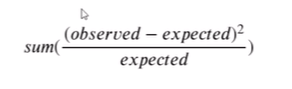

In [15]:
Image("../imgs/chi2_manual.png")

In [16]:
observed = df2.loc['aleatoria']

afirmacao_ratio = df2.loc['afirmacao'] / df2.loc['afirmacao'].sum()

expected = afirmacao_ratio * df2.loc['aleatoria'].sum()

chi_squared_stat = (((observed-expected) ** 2)/expected).sum()
chi_squared_stat

19.583333333333336

In [17]:
crit = stats.chi2.ppf(q=0.95, 
                      df=len(df2.columns)-1) 

print(f"Critical value: {crit}")

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,      # cumulative distribution function (area under)
                            df=len(df2.columns)-1) 

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Critical value: 5.991464547107979
P value: 5.591562685636209e-05
Rejeita a nula


### Experimento -  Chi2

In [18]:
chi_squared_stat, pvalue = stats.chisquare(f_obs=df2.loc['aleatoria'],
                f_exp=df2.loc['afirmacao'])

print(f"Statistic: {chi_squared_stat}")

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Statistic: 19.583333333333336
P value: 5.591562685636209e-05
Rejeita a nula


# 3. Pesquisa Eleitoral - Independência
Uma empresa de pesquisa perguntou a preferência de votos entre 1000 eleitores
aleatórios, dividido entre homens e mulheres.
O resultado é mostrado na tabela de contingência abaixo.
Republicado Democrata Independente Total da Linha
Homens 200 150 50 400
Mulheres 250 300 50 600
Total 450 450 100 1000
Existe uma diferença entre o eleitores de diferente gênero? As preferências dos
homens se diferem significativamente das preferências das mulheres? Use um nível
de significância de 0.05

- H0: A preferência partidária é independente ao sexo da pessoa.
- H1: A preferência partidária não é independente ao sexo da pessoa.

In [19]:
df3 = pd.DataFrame({'Homens':[200, 150, 50], 'Mulheres':[250, 300, 50],
                    'Partido':['Republicado', 'Democrata', 'Independente']})
df3 = df3.set_index('Partido')
df3['Total'] = df3.sum(axis=1)
df3.loc['Total'] = df3.sum(axis=0)
df3 = df3.T.copy()
df3

Partido,Republicado,Democrata,Independente,Total
Homens,200,150,50,400
Mulheres,250,300,50,600
Total,450,450,100,1000


### Experimento -  Cálculo manual - Chi2

In [20]:
observed = df3.drop('Total', axis=1).drop('Total', axis=0)

expected = np.outer(df3['Total'][0:2],
                    df3.loc['Total'][0:3]) / 1000

expected = pd.DataFrame(expected)

expected.columns = df3.columns.drop('Total')
expected.index = df3.index.drop('Total')

expected

Partido,Republicado,Democrata,Independente
Homens,180.0,180.0,40.0
Mulheres,270.0,270.0,60.0


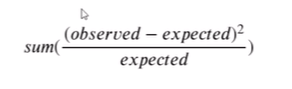

In [21]:
Image("../imgs/chi2_manual.png")

In [22]:
chi_squared_stat = (((observed-expected) ** 2)/expected).sum().sum()
chi_squared_stat

16.203703703703706

In [23]:
crit = stats.chi2.ppf(q=0.95, 
                      df= (len(observed)-1) *  (len(observed.columns)-1))

print(f"Critical value: {crit}")

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,
                            df= (len(observed)-1) *  (len(observed.columns)-1))

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Critical value: 5.991464547107979
P value: 0.00030297754871455584
Rejeita a nula


### Experimento -  Chi2

In [24]:
stats.chi2_contingency(observed=observed)

(16.203703703703702,
 0.0003029775487145488,
 2,
 array([[180., 180.,  40.],
        [270., 270.,  60.]]))

In [25]:
chi_squared_stat,p_value,_,_= stats.chi2_contingency(observed=observed)

print(f"Statistic: {chi_squared_stat}")

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Statistic: 16.203703703703702
P value: 0.0003029775487145488
Rejeita a nula


**Não é possível afirmar que a preferência partidária é independente ao sexo da pessoa.**

# 4. Altura das Meninas
Precisamos determinar se as meninas, na média, tiram uma nota maior do que 600
na prova. Nós temos a informação de que as meninas tem um desvio padrão de
nota igual a 100.
Então, nós coletamos dados de 20 meninas usando uma amostragem aleatória e
armazenamos na lista abaixo.
Podemos dizer que as meninas, em média, tiram notas maiores que 600?
Assumindo um nível de significância de 0.05
data = [650,730,510,670,480,800,690,530,590,620,710,670,640,780,650,490,800,600,510]

- H0: A média das notas não é maior que 600
- H1: A média das notas é maior que 600

In [26]:
notas = [650,730,510,670,480,800,690,530,590,620,710,670,640,780,650,490,800,600,510,700]

In [27]:
sample_mean = np.mean(notas)
sample_size = 49

pop_mean = 600
pop_std = 100

In [28]:
stats.shapiro(notas)

ShapiroResult(statistic=0.9491577744483948, pvalue=0.3544860780239105)

In [29]:
_, p_value = stats.mannwhitneyu(x=notas, y=pop_mean, alternative='greater')

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

P value: 0.30986256978542653
Falhou em rejeitar a nula


### Revisando com ztest (Aula)

In [30]:
_, p_value = ssapi.ztest(x1=notas,value=pop_mean, alternative='larger')
print(f'p value: {p_value}')

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

p value: 0.03349471703839336
Rejeita a nula


# 5. Entrega da farmácia
Um farmácia afirma que a média do tempo de entrega dos medicamentos é menor
do que 120 minutos com desvio padrão de 30 minutos.
Foram selecionadas 49 entregas aleatória e o tempo médio essas entregas foi de
100 minutos.
Há evidências suficientes para confirmar a afirmação da farmácia com 0.05 de nível
de significância?

- H0: A média do tempo de entrega é igual a 120 minutos
- H1: A média do tempo de entrega é menor que 120 minutos

In [31]:
sample_mean = 100
sample_size = 49

pop_mean = 120
pop_std = 30

In [32]:
data = np.random.normal(loc=sample_mean, size=sample_size, scale=pop_std).astype(int)
data

array([ 76, 119,  65, 113,  95,  76,  67, 117,  86,  78, 122,  55, 127,
       102,  77, 130,  80,  67, 106,  91, 150, 124, 122, 133, 155,  84,
        94,  85,  86, 175,  90,  54, 154,  66, 136, 106,  67, 119, 102,
       107,  59, 145, 113,  74, 108,  95,  65,  99,  94])

In [33]:
_, p_value = ssapi.ztest(x1=data,value=pop_mean, alternative='smaller')
print(f'p value: {p_value}')

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

p value: 8.667690246178433e-07
Rejeita a nula


# 6. Defeitos na empresa
Uma empresa quer melhorar a qualidade dos produtos reduzindo os defeitos e
monitorando a eficiência das linhas de montagem. A linha de montagem A, havia 18
defeitos relatados de 200 amostras selecionadas aleatoriamente, enquanto 25
defeitos de 600 amostras foram relatadas na linha de montagem B.
Há uma diferença entre as linhas de produção em um nível de significância de 0.05?

- H0: Não há diferença entre as linhas de produção A e B
- H1: Há diferença entre as linhas de produção A e B

In [34]:
df6 = pd.DataFrame({'amostras':[200, 600], 'defeitos':[18, 25], 'linha':['A', 'B']})
df6 = df6.set_index('linha')

df6['nao_defeitos'] = df6['amostras'] - df6['defeitos']
df6['percentual_defeitos'] = df6['defeitos'] / df6['amostras']
df6

,amostras,defeitos,nao_defeitos,percentual_defeitos
linha,,,,
A,200,18,182,0.090000
B,600,25,575,0.041667


### Experimento - Z Test

In [35]:
x1 = [0]*df6.loc['A', 'nao_defeitos'] + [1]*df6.loc['A', 'defeitos']
x2 = [0]*df6.loc['B', 'nao_defeitos'] + [1]*df6.loc['B', 'defeitos']

In [36]:
_, p_value = ssapi.ztest(x1=x1,x2=x2)
print(f'p value: {p_value}')

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

p value: 0.008465853950233563
Rejeita a nula


# 7. Nível de Educação
Pesquisadores gostariam de saber se o estado civil está associado com o nível de
educação. Para isso, eles entrevistaram 300 pessoas aleatoriamente e obtiveram os
seguintes resultados:
High School Bachelor’s
Master’s or
Higher
Total
Married 20 100 35 155
Single 50 80 15 145
Total 70 180 50 300

- H0: O nível de educação é independente ao estado civil da pessoa.
- H1: O nível de educação não é independente ao estado civil da pessoa.

In [37]:
df7 = pd.DataFrame({'casados':[20, 100, 35], 'solteiros':[50, 80, 15],
                    'educacao':['High School Bachelor’s', 'Master’s', 'Higher']})
df7 = df7.set_index('educacao')
df7['Total'] = df7.sum(axis=1)
df7.loc['Total'] = df7.sum(axis=0)
df7 = df7.T.copy()
df7

educacao,High School Bachelor’s,Master’s,Higher,Total
casados,20,100,35,155
solteiros,50,80,15,145
Total,70,180,50,300


In [38]:
observed = df7.drop('Total', axis=1).drop('Total', axis=0)
observed

educacao,High School Bachelor’s,Master’s,Higher
casados,20,100,35
solteiros,50,80,15


### Experimento -  Chi2

In [39]:
stats.chi2_contingency(observed=observed)

(22.771333227395516,
 1.1357109599633353e-05,
 2,
 array([[36.16666667, 93.        , 25.83333333],
        [33.83333333, 87.        , 24.16666667]]))

In [40]:
chi_squared_stat,p_value,_,_= stats.chi2_contingency(observed=observed)

print(f"Statistic: {chi_squared_stat}")

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Statistic: 22.771333227395516
P value: 1.1357109599633353e-05
Rejeita a nula


**Não é possível afirmar que o nível de educação é independente ao estado civil da pessoa.**

# 8. Dono da Loja
O dono da loja afirma que um número igual de clientes visitam a sua loja cada dia
da semana. Para testar essa hipótese, um Cientista de Dados registrou um número
de clientes que visitaram a loja em uma determina semana e encontrou os seguinte
números:
High School
Segunda 50
Terça 60
Quarta 40
Quinta 47
Sexta 53
Os dados são consistentes com a afirmação do dono da loja?

- H0: Não há diferença no número de visitas ao longo da semana
- H1: Há diferença no número de visitas ao longo da semana

In [41]:
df8 = pd.DataFrame([{'segunda': 50,'terca': 60, 'quarta': 40, 'quinta': 47, 'sexta':53}], index=['visitas'])
df8

,segunda,terca,quarta,quinta,sexta
visitas,50,60,40,47,53


In [42]:
expected = [df8.loc['visitas'].mean() for _ in range(len(df8.columns))]

In [47]:
chi_squared_stat, p_value = stats.chisquare(f_obs=df8.loc['visitas'],
                f_exp=expected)

print(f"Statistic: {chi_squared_stat}")

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

Statistic: 4.359999999999999
P value: 0.3594720674366307
Falhou em rejeitar a nula


# 9. Método de estudo
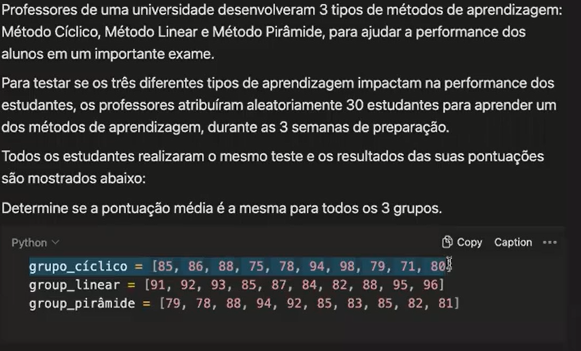

One way Anova --> Como um fator(grupo de estudo) impacta na nota

- H0: Não há diferença significativa na pontuação média entre os 3 grupos
- H1: Há diferença significativa na pontuação média entre os 3 grupos

In [52]:
grupo_ciclico = [85, 86, 88, 75, 78, 94, 98, 79, 71, 80]
grupo_linear = [91, 92, 93, 85, 87, 84, 82, 88, 95, 96]
grupo_piramide = [79, 78, 88, 94, 92, 85, 83, 85, 82, 81]

### Teste - ANOVA

In [55]:
anova_stat, p_value = stats.f_oneway(grupo_ciclico,grupo_linear, grupo_piramide)

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

P value: 0.11384795345837218
Falhou em rejeitar a nula


### Premissas

#### Variância das amostras iguais

In [75]:
df = pd.DataFrame({'grupo_ciclico': grupo_ciclico,'grupo_linear':  grupo_linear,'grupo_piramide':  grupo_piramide})
df = df.melt(value_name='nota', var_name='metodo')
df

,metodo,nota
0,grupo_ciclico,85
1,grupo_ciclico,86
2,grupo_ciclico,88
3,grupo_ciclico,75
4,grupo_ciclico,78
5,grupo_ciclico,94
6,grupo_ciclico,98
7,grupo_ciclico,79
8,grupo_ciclico,71
9,grupo_ciclico,80


- Boxplot

<AxesSubplot:xlabel='metodo', ylabel='nota'>

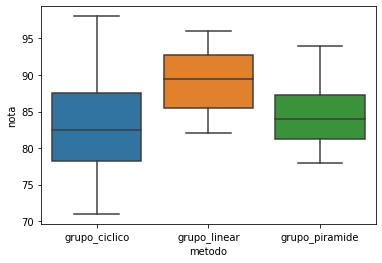

In [77]:
sns.boxplot(x='metodo', y='nota', data=df)

- Barlett Test
    - H0: A variancia é igual para todas as amostras
    - H1: A variancia não é igual para alguma das amostras

In [81]:
barlett_stat, p_value = stats.bartlett(grupo_ciclico,grupo_linear, grupo_piramide)

print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

P value: 0.19181598314035977
Falhou em rejeitar a nula


#### Normalidade

- Distribuição

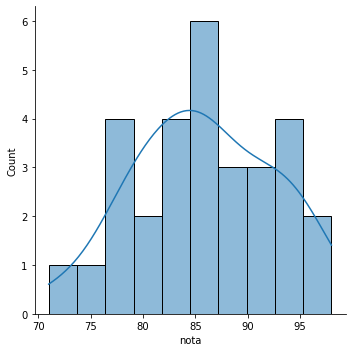

In [95]:
sns.displot(df['nota'], kde=True, bins=10);

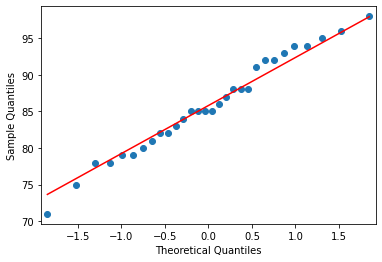

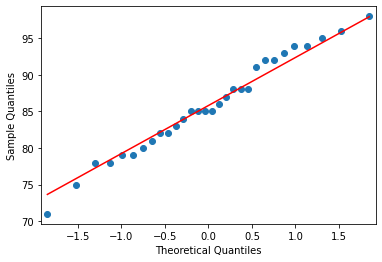

In [103]:
from statsmodels.api import qqplot
qqplot(df['nota'], line='s')

- Shapiro
    - H0: A população (3 amostras) é normalmente distribuída.
    - H1: A população (3 amostras) não é normalmente distribuída.

In [87]:
shapiro_stat, p_value = stats.shapiro(df['nota'])
print(f"P value: {p_value}")

if p_value< 0.05:
    print('Rejeita a nula')
else:
    print('Falhou em rejeitar a nula')

P value: 0.8451867699623108
Falhou em rejeitar a nula


# 10. Campanha de Marketing
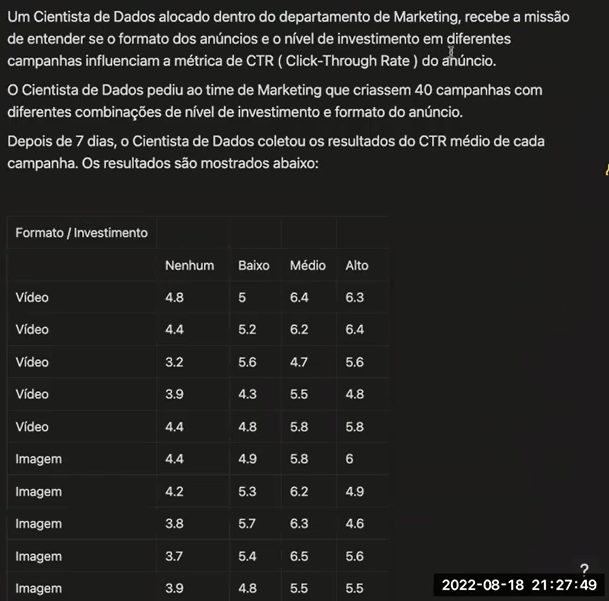

Two way Anova --> Como dois fatores(formato, investimento) impacta na nota

- H0: Não há diferença significativa do CTR entre os 3 grupos
- H1: Há diferença significativa entre do CTR entre os 3 grupos

In [110]:
from statsmodels.formula.api import ols

In [107]:
nenhum = [4.8, 4.4, 3.2, 3.9, 4.4, 4.4, 4.2, 3.8, 3.7, 3.9]
baixo = [5, 5.2, 5.6, 4.3, 4.8, 4.9, 5.3, 5.7, 5.4, 4.8]
medio = [6.4, 6.2, 4.7, 5.5, 5.8, 5.8, 6.2, 6.3, 6.5, 5.5]
alto = [6.3, 6.4, 5.6, 4.8, 5.8, 6, 4.9, 4.6, 5.6, 5.5]
formato = ['video', 'video', 'video', 'video', 'video', 'imagem', 'imagem', 'imagem', 'imagem', 'imagem']
df = pd.DataFrame({'formato': formato, 'nenhum': nenhum, 'baixo': baixo, 'medio': medio, 'alto': alto})

df = df.melt(id_vars='formato', value_name='ctr', var_name='investimento')
df.head()

,formato,investimento,ctr
0,video,nenhum,4.8
1,video,nenhum,4.4
2,video,nenhum,3.2
3,video,nenhum,3.9
4,video,nenhum,4.4


In [113]:
# ctr = formato + investimento + relacao entre formato e investimento (combinados de alguma forma)
model = ols('ctr ~ C(formato) + C(investimento) + C(formato):C(investimento)', data=df).fit()

In [117]:
from statsmodels.stats.api import anova_lm

In [119]:
results = anova_lm(model, typ=2)

In [126]:
display(results.round(7))
print('O unico valor que consegue explicar significamente o CTR é o investimento (p_value < 0.05). ')

,sum_sq,df,F,PR(>F)
C(formato),0.00025,1.0,0.000921,0.975975
C(investimento),18.76475,3.0,23.048979,0.000000
C(formato):C(investimento),1.01075,3.0,1.241517,0.310898
Residual,8.68400,32.0,NaN,NaN


O unico valor que consegue explicar significamente o CTR é o investimento (p_value < 0.05). 
